импортируем все библиотеки

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

объявляем константы

In [8]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42
DATASET_PATH = './petfaces'

скачиваем и распаковываем архив с данными

!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

функция для загрузки датасета

In [3]:
def load_dataset(dataset_path):
    images = []
    binary_labels = [] # 0 == кот, 1 == собака, решил в этом случае не использовать enum
    breed_labels = []
    breed_names = []
    
    class_dirs = sorted(os.listdir(dataset_path))
    
    for i, class_dir in enumerate(class_dirs):
        class_path = os.path.join(dataset_path, class_dir)
        if not os.path.isdir(class_path):
            continue
            
        pet_type = 1 if class_dir.startswith('dog_') else 0
        breed_name = class_dir
        
        if breed_name not in breed_names:
            breed_names.append(breed_name)
            
        print(f"Loading {breed_name} images...")
        
        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
                
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(img) / 255.0
                
                images.append(img_array)
                binary_labels.append(pet_type)
                breed_labels.append(breed_names.index(breed_name))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(binary_labels), np.array(breed_labels), breed_names

создадим CNN для бинарной классификации и для классификации пород

In [4]:
def create_binary_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_breed_model(num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    # Freeze the base model
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

рассчитаем точность и построим матрицу ошибок

In [13]:
def top_k_accuracy(y_true, y_pred, k=3):
    top_k_preds = np.argsort(-y_pred, axis=1)[:, :k]
    matches = [y_true[i] in top_k_preds[i] for i in range(len(y_true))]
    return np.mean(matches)

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

загрузим датасет

In [9]:
X, y_binary, y_breed, breed_names = load_dataset(DATASET_PATH)

X_train, X_test, y_binary_train, y_binary_test, y_breed_train, y_breed_test = train_test_split(
    X, y_binary, y_breed, test_size=TEST_SIZE, stratify=y_breed, random_state=RANDOM_STATE
)

print(f"Всего {len(X_train)} тренировочных записей, {len(X_test)} записей для тестирования")

Loading cat_Abyssinian images...
Loading cat_Bengal images...
Loading cat_Birman images...
Loading cat_Bombay images...
Loading cat_British images...
Loading cat_Egyptian images...
Loading cat_Maine images...
Loading cat_Persian images...
Loading cat_Ragdoll images...
Loading cat_Russian images...
Loading cat_Siamese images...
Loading cat_Sphynx images...
Loading dog_american images...
Loading dog_basset images...
Loading dog_beagle images...
Loading dog_boxer images...
Loading dog_chihuahua images...
Loading dog_english images...
Loading dog_german images...
Loading dog_great images...
Loading dog_havanese images...
Loading dog_japanese images...
Loading dog_keeshond images...
Loading dog_leonberger images...
Loading dog_miniature images...
Loading dog_newfoundland images...
Loading dog_pomeranian images...
Loading dog_pug images...
Loading dog_saint images...
Loading dog_samoyed images...
Loading dog_scottish images...
Loading dog_shiba images...
Loading dog_staffordshire images...
L

построим и обучим модель для классификации существ (кот/собака)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9156 - loss: 0.2052 - val_accuracy: 0.9813 - val_loss: 0.0485
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9898 - loss: 0.0322 - val_accuracy: 0.9876 - val_loss: 0.0421
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9948 - loss: 0.0217 - val_accuracy: 0.9891 - val_loss: 0.0384
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9969 - loss: 0.0118 - val_accuracy: 0.9891 - val_loss: 0.0390
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9767 - val_loss: 0.0604
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
Точность: 0.9767


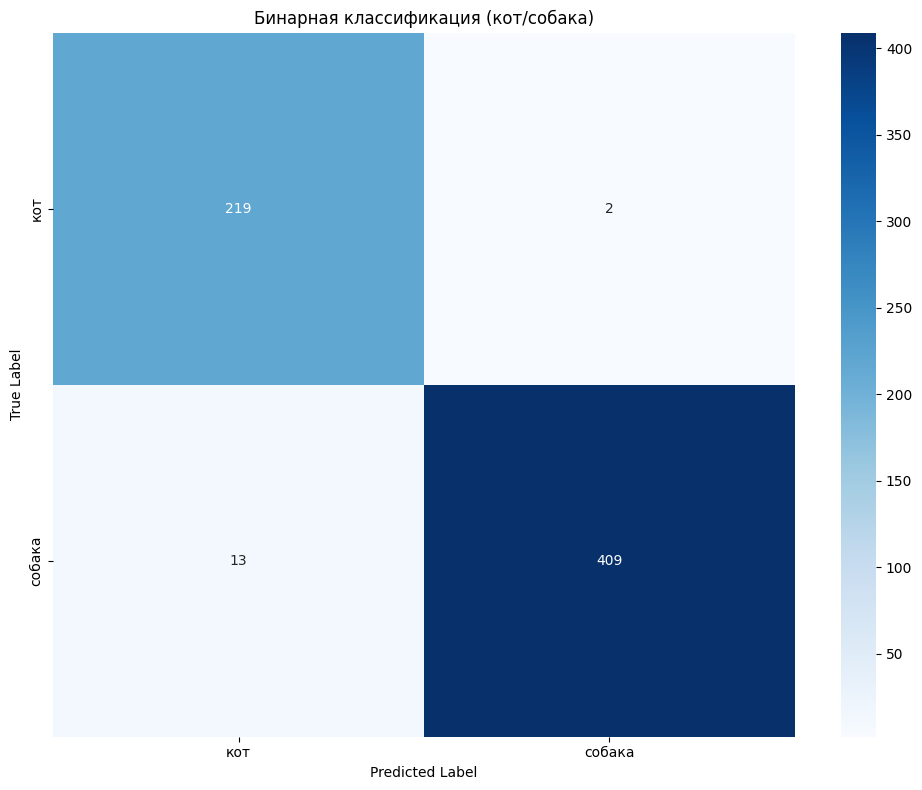

In [14]:
binary_model = create_binary_model()
binary_model.fit(
    X_train, y_binary_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_binary_test)
)

binary_preds_prob = binary_model.predict(X_test)
binary_preds = (binary_preds_prob > 0.5).astype(int).flatten()
binary_accuracy = accuracy_score(y_binary_test, binary_preds)

print(f"Точность: {binary_accuracy:.4f}")
plot_confusion_matrix(y_binary_test, binary_preds, ['кот', 'собака'], "Бинарная классификация (кот/собака)")

построим и обучим модель для классификации пород


--- Классификация пород ---
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.3314 - loss: 2.5531 - val_accuracy: 0.7387 - val_loss: 0.8514
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7648 - loss: 0.7800 - val_accuracy: 0.7838 - val_loss: 0.7003
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8427 - loss: 0.5151 - val_accuracy: 0.7932 - val_loss: 0.6084
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8817 - loss: 0.3565 - val_accuracy: 0.8165 - val_loss: 0.5777
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9176 - loss: 0.2581 - val_accuracy: 0.8072 - val_loss: 0.5870
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
Точность: 0.8072
Точность Top-3: 0.9487


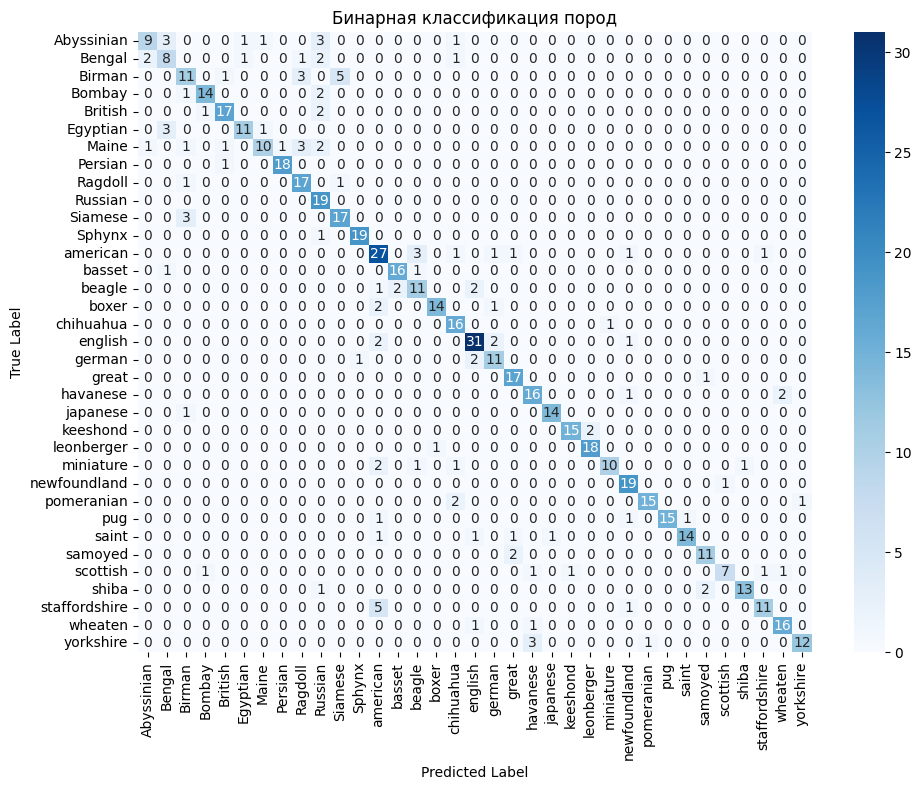

In [15]:
print("\n--- Классификация пород ---")
num_breeds = len(breed_names)
breed_model = create_breed_model(num_breeds)
breed_model.fit(
    X_train, y_breed_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_breed_test)
)

breed_preds_prob = breed_model.predict(X_test)
breed_preds = np.argmax(breed_preds_prob, axis=1)
breed_accuracy = accuracy_score(y_breed_test, breed_preds)
top3_accuracy = top_k_accuracy(y_breed_test, breed_preds_prob, k=3)

print(f"Точность: {breed_accuracy:.4f}")
print(f"Точность Top-3: {top3_accuracy:.4f}")

simplified_breed_names = [name.replace('cat_', '').replace('dog_', '') for name in breed_names]
plot_confusion_matrix(y_breed_test, breed_preds, simplified_breed_names, "Бинарная классификация пород")